In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from pathlib import Path

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import re

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

# convert dictionary to pandas dataframe
CHAR2ORD_DF = pd.DataFrame(CHAR2ORD.values(),index=CHAR2ORD.keys(),columns=['Ordinal Encoding'])
CHAR2ORD_DF.head()

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4


In [5]:
# Number of Unique Characters
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}') # ends in number 58

N_UNIQUE_CHARACTERS: 59


In [6]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Describe Statistics Percentiles
PERCENTILES = [0.01, 0.10, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Fast Processing
FAST= False
# Number of Unique Characters To Predict + Pad Token + Start of sentence and end of sentence Token 
N_UNIQUE_CHARACTERSPAD_TOKEN = len(CHAR2ORD) # Padding = 59
START_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence = 60
END_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence = 61


In [7]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

train.head()


,path,file_id,sequence_id,participant_id,phrase,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...


In [8]:
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)

train.head(10)


,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address
5,train_landmarks/5414471.parquet,5414471,1817141095,38,www.freem.ne.jp,/kaggle/input/asl-fingerspelling/train_landmar...,url
6,train_landmarks/5414471.parquet,5414471,1817169529,70,https://jsi.is/hukuoka,/kaggle/input/asl-fingerspelling/train_landmar...,url
7,train_landmarks/5414471.parquet,5414471,1817171518,202,239613 stolze street,/kaggle/input/asl-fingerspelling/train_landmar...,address
8,train_landmarks/5414471.parquet,5414471,1817195757,136,242-197-6202,/kaggle/input/asl-fingerspelling/train_landmar...,phone_number
9,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,/kaggle/input/asl-fingerspelling/train_landmar...,address


In [9]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train.set_index('sequence_id')

train.head()

MAX_PHRASE_LENGTH: 31


,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


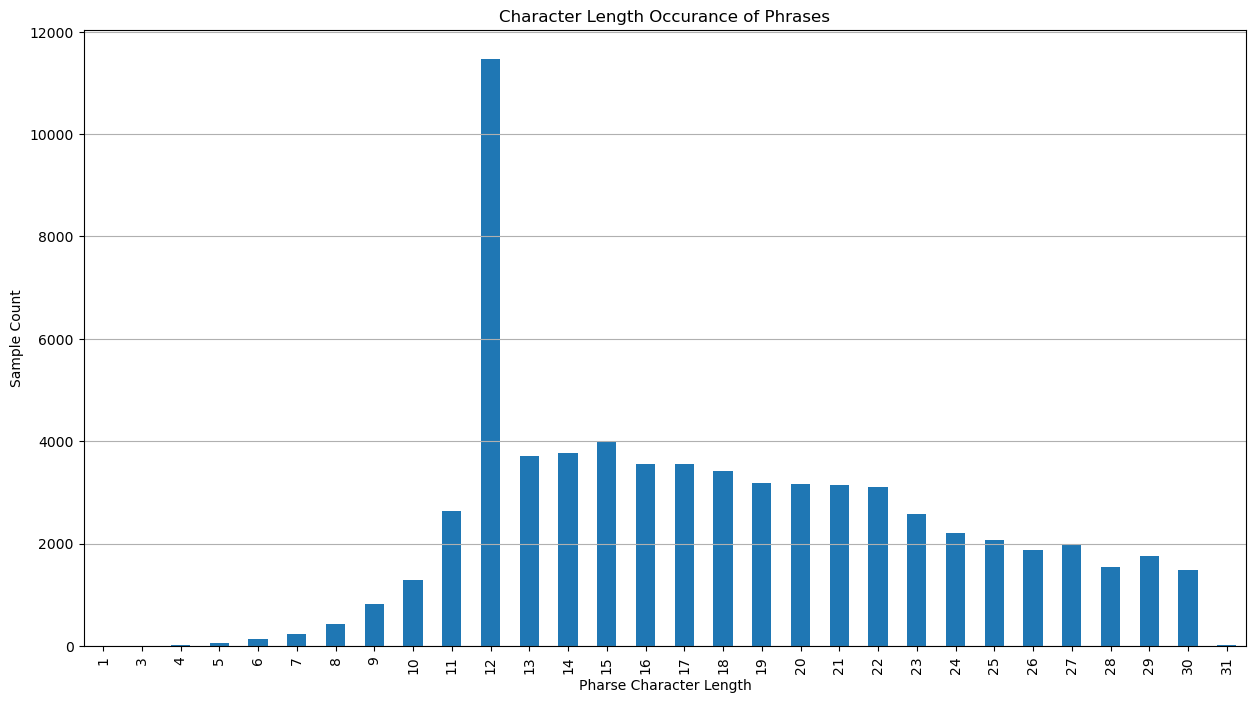

In [10]:
# Character Count Occurance
plt.figure(figsize=(15,8))
plt.title('Character Length Occurance of Phrases')
train['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, train['phrase_char_len'].max() - 1.50)
plt.xlabel('Pharse Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

In [11]:
# Read First Parquet File
example_parquet_df = pd.read_parquet(train['file_path'][0])

# Each parquet file contains 1000 unique recordings
print(f'Number of Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
example_parquet_df.head()

Number of Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Number of parquet chunks to analyse
N = 5 if IS_INTERACTIVE else 25
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique()) # total file paths

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path) # read the parquet 
    for group, group_df in df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

  0%|          | 0/25 [00:00<?, ?it/s]

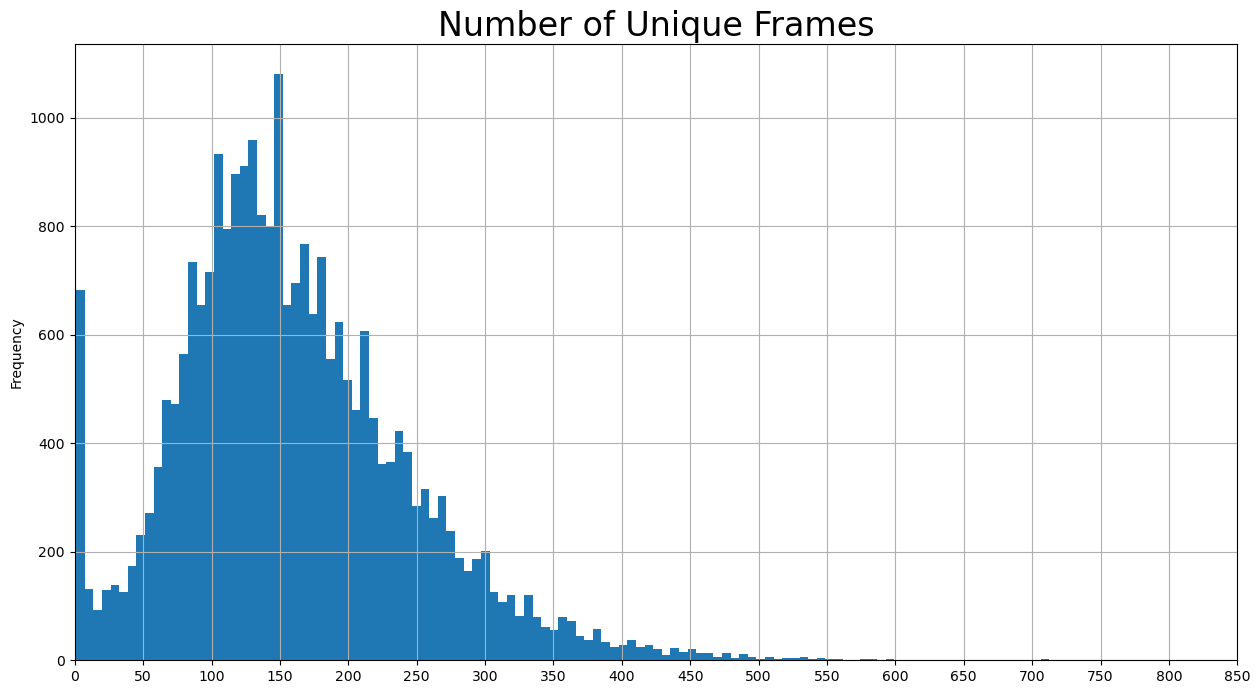

In [13]:
plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+50, 50))
plt.show()


In [14]:
def get_idxs(df, words_pos, words_neg=['z'], ret_names=True, idxs_pos=None):
    # words_pos is the first element we want to select : ['face','right_hand','left_hand','pose']
    # words_neg are the components we want to exclude: ['x','y','z']
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [15]:
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [16]:
print(f' Indexes of the left hand: {LEFT_HAND_IDXS0.tolist()}')
print(f'\n Indexes of the lips: {LIPS_IDXS0.tolist()}')

 Indexes of the left hand: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

 Indexes of the lips: [0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415, 0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415]


In [17]:
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
# obtain indices of the LEFT_HAND_NAMES0 in COLUMNS0
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
N_COLS = N_COLS0
# Only x and y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [18]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

In [19]:
class PreprocessLayerNonNaN(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayerNonNaN, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Add another dimension
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84]) # 84 its 21 x 4, left_hand, right_hand and x,y
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer_non_nan = PreprocessLayerNonNaN()

In [20]:
df = pd.read_parquet(file_path)
for group, group_df in df.groupby('sequence_id'):
    # extract sequence_id = group and the rest of the dataframe = group_df
    datagroup = group
    datagroupdf = group_df

display(datagroupdf[COLUMNS0].iloc[:,:84].head())
print('\n')
display(datagroup)

,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
958123277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.556164,0.510718,0.694879,0.657876,0.698813,0.730055,0.727584,0.720957,0.755511,0.781221
958123277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
958123277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
958123277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.620880,0.640386,0.653936,0.626285,0.655760,0.682551,0.670947,0.667219,0.689518,0.708173
958123277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.616302,0.637068,0.646813,0.633997,0.660512,0.686655,0.664586,0.659912,0.676864,0.695157


958123277

In [21]:
# Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
# Number of parquet chunks to analyse
N = 5 if (IS_INTERACTIVE or FAST) else len(UNIQUE_FILE_PATHS)
# Number of Non Nan Frames in Recording
N_NON_NAN_FRAMES = []

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        # group = sequence_id 
        # group_df = the rest of the dataframe (left_hand, right_hand,...)
        # preprocess the left hand and right hand values for that sequence id
        frames = preprocess_layer_non_nan(group_df[COLUMNS0].values).numpy()
        # append the number of frames that are not NaN
        N_NON_NAN_FRAMES.append(len(frames))

# Convert to Numpy Array
N_NON_NAN_FRAMES = pd.Series(N_NON_NAN_FRAMES).to_frame('# Frames')

  0%|          | 0/68 [00:00<?, ?it/s]

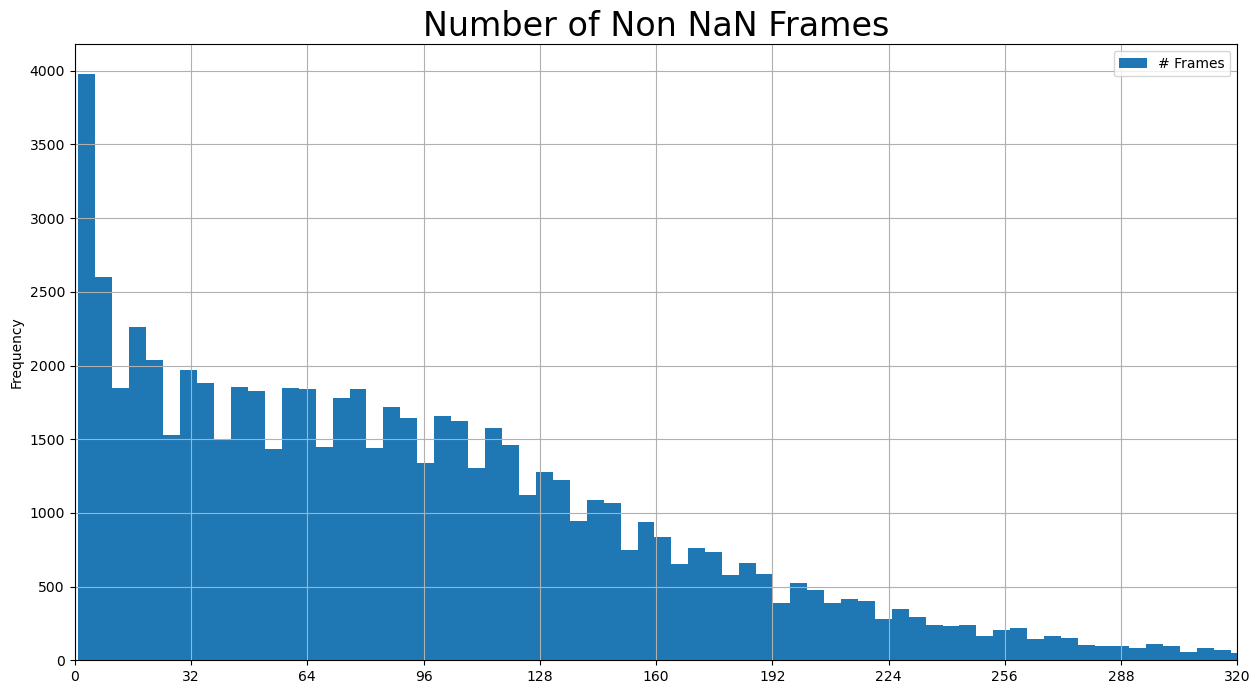

In [22]:
N_NON_NAN_FRAMES.plot(kind='hist', bins=128, figsize=(15,8))
plt.title('Number of Non NaN Frames', size=24)
plt.grid()
xlim = np.percentile(N_NON_NAN_FRAMES, 99)
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+32, 32))
plt.show()

In [23]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Add another dimension
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Padding with Zeros
        N_FRAMES = len(data[0]) # set N_FRAMES as the original length of the data
        if N_FRAMES < N_TARGET_FRAMES: 
            # N_TARGET_FRAMES = 128
            # then we use padding 
            data = tf.concat((
                data,    
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES], # [1,128]
            method=tf.image.ResizeMethod.BILINEAR,)
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

inputs = group_df[COLUMNS0].values # 164 columns (left_hand,right_hand,face) 
# dimension -> [n_rows, n_columns = 164]
print(inputs.shape) 
inputs = inputs[:1] # select the first row for the 164 columns
# dimension -> [1, 164]
print(inputs.shape)

frames = preprocess_layer(inputs) # Use PreprocessLayer in the example parquet

print(f'inputs shape: {inputs.shape}, NaN count: {np.isnan(inputs).sum()}')
print(f'frames shape: {frames.shape}, NaN count: {np.isnan(frames).sum()}')

(95, 164)
(1, 164)
inputs shape: (1, 164), NaN count: 42
frames shape: (128, 164), NaN count: 0


In [24]:
''' define data to preprocess'''
inputs = group_df[COLUMNS0].values # 164 columns (left_hand,right_hand,face) 
# dimension -> [n_rows, n_columns = 164]
print(inputs.shape) 
inputs = inputs[:1] # select the first row for the 164 columns
# dimension -> [1, 164]
print(inputs.shape)

(95, 164)
(1, 164)


In [25]:
data = tf.where(tf.math.is_nan(inputs), 0.0, inputs)    
print(f' elementos 40:45 del array "inputs" : {inputs[:,40:45]}')
print(f'\n elementos 40:45 del array "data" : {data[:,40:45]}\n')
# Add another dimension
data = data[None]
print(f' shape del array "data" : {data.shape}') 

 elementos 40:45 del array "inputs" : [[0.7017309 0.7142179       nan       nan       nan]]

 elementos 40:45 del array "data" : [[0.7017309 0.7142179 0.        0.        0.       ]]

 shape del array "data" : (1, 1, 164)


In [26]:
# Empty Hand Frame Filtering
hands = tf.slice(data, [0,0,0], [-1, -1, 84])
print(hands)

tf.Tensor(
[[[0.58183986 0.508551   0.47036737 0.43600988 0.405158   0.58362573
   0.48489186 0.47441432 0.4881848  0.6231533  0.49852148 0.49292138
   0.514569   0.64947885 0.52340573 0.5189808  0.54269797 0.6629799
   0.5639835  0.5498223  0.56835365 0.7883195  0.74421793 0.6955489
   0.6651089  0.63506496 0.633117   0.6260123  0.6555631  0.6703955
   0.6364882  0.63724756 0.67256075 0.6872084  0.6513127  0.65690684
   0.6917033  0.7037142  0.674782   0.6752764  0.7017309  0.7142179
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]]], shape=(1, 1, 84), dtype=float32)


In [27]:
hands = tf.abs(hands) # original values [-1,1] -> make then [0,1] to make the sum
mask = tf.reduce_sum(hands, axis=2) # sum of all the values
print(f'\n')
mask = tf.not_equal(mask, 0) # is this is True, this frame contains hand information
print(f'\n does the frame contain information? : {mask}') 
print(f'\n is bool value its True : {data[mask][None]}') # select or not the values
print(f'\n is bool value its False : {data[tf.fill(data.shape, False)][None]}')





 does the frame contain information? : [[ True]]

 is bool value its True : [[[0.58183986 0.508551   0.47036737 0.43600988 0.405158   0.58362573
   0.48489186 0.47441432 0.4881848  0.6231533  0.49852148 0.49292138
   0.514569   0.64947885 0.52340573 0.5189808  0.54269797 0.6629799
   0.5639835  0.5498223  0.56835365 0.7883195  0.74421793 0.6955489
   0.6651089  0.63506496 0.633117   0.6260123  0.6555631  0.6703955
   0.6364882  0.63724756 0.67256075 0.6872084  0.6513127  0.65690684
   0.6917033  0.7037142  0.674782   0.6752764  0.7017309  0.7142179
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.33904597 0

In [28]:
data = data[mask][None] # select or not the values

# Padding with Zeros
N_FRAMES = len(data[0]) # N_FRAMES as the original length of the data 
print(f'number of frames of the video : {N_FRAMES}')
print('\n')
if N_FRAMES < N_TARGET_FRAMES: 
    # N_TARGET_FRAMES = 128
    # then we use padding 
    print(f'Original shape of the data pre concat : {data.shape}')
    newdata = tf.concat((
                data,   # [1,1,164]  
                        # [1,128-1,164] -> concat the two produces [1,128,164]
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)),
                axis=1) # will add 127 in 2nd dimension full of zeros 
    print(f'\n Resulting tensor post concat : {newdata.shape}')
    print('\n')
    print(f'\n First vector in 2nd dimension : {newdata[:,0,:]}')
    print(f'\n  Rest of the vectors (127) : {newdata[:,10,:]}')
    
    # Now we have a Tensor with shape [1,128,164]
    
    # Downsample
    newdata = tf.image.resize(
            newdata,
            [1, N_TARGET_FRAMES], # [1,128,164]
            method=tf.image.ResizeMethod.BILINEAR,)
    # in this particular case it doesnt change nothing,
    # because our tensor was already [1,128,164]
    
    # Delete First Dimension (Batch dimension)
    newdata = tf.squeeze(newdata, axis=[0])
print(f'\n Final result : {newdata.shape}') 

number of frames of the video : 1


Original shape of the data pre concat : (1, 1, 164)

 Resulting tensor post concat : (1, 128, 164)



 First vector in 2nd dimension : [[0.58183986 0.508551   0.47036737 0.43600988 0.405158   0.58362573
  0.48489186 0.47441432 0.4881848  0.6231533  0.49852148 0.49292138
  0.514569   0.64947885 0.52340573 0.5189808  0.54269797 0.6629799
  0.5639835  0.5498223  0.56835365 0.7883195  0.74421793 0.6955489
  0.6651089  0.63506496 0.633117   0.6260123  0.6555631  0.6703955
  0.6364882  0.63724756 0.67256075 0.6872084  0.6513127  0.65690684
  0.6917033  0.7037142  0.674782   0.6752764  0.7017309  0.7142179
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

In [29]:
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

# Target Arrays Processed Input Videos
X = np.zeros([N_SAMPLES, N_TARGET_FRAMES, N_COLS], dtype=np.float32)
print(f'\nX Shape : {X.shape}')
# Ordinally Encoded Target With value 59 for pad token
y = np.full(shape=[N_SAMPLES, N_TARGET_FRAMES], fill_value=N_UNIQUE_CHARACTERS, dtype=np.int8)
print(f'\ny Shape : {y.shape}')
# Phrase Type
y_phrase_type = np.empty(shape=[N_SAMPLES], dtype=object)
print(f'\ny_phrase_type Shape : {y_phrase_type.shape}')


N_SAMPLES: 67208

X Shape : (67208, 128, 164)

y Shape : (67208, 128)

y_phrase_type Shape : (67208,)


In [30]:
train.head()

,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,url,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


In [31]:
# All unique parquet files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

In [32]:
i = 0
for idx, file_path in enumerate((UNIQUE_FILE_PATHS)):
    print(f'Index of the dataframe : {idx}')
    print(f'File path : {file_path}')
    # read the parquet corresponding to that path
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1] # parquet name (ex : 105143404.parquet)
    print(f'File name : {name}')
    if idx < 10: # first 10 values
        display(df[COLUMNS0].head())
        # make it parquet again and save it in /kaggle/working/train_landmark_subsets
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # this is just to stop at three iters
    print('\n\n')
    i += 1 
    if i == 1:
        break

Index of the dataframe : 0
File path : /kaggle/input/asl-fingerspelling/train_landmarks/5414471.parquet
File name : 5414471.parquet


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


In [33]:
# All unique parquet files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
i = 0
stop = False
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Print the progress
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verification
    name = file_path.split('/')[-1] # parquet name (ex : 105143404.parquet)
    if idx < 10: # first 10 values
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1
        
        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        print(f'frames shape : {frames.shape}\n')
        # Assign
        X[row] = frames # each row contains a 128,164 tensor
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            # for every column and character
            y[row, col] = CHAR2ORD.get(char) # set in corresponding row 
            
        # Add End of Sentence Token = 61
        y[row, col+1] = END_TOKEN # 61
        print(f'y[row,:] :')
        print(f'----------------------------------------------------------')
        print(f'{y[row,:]}\n')
        print(f'----------------------------------------------------------')
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        print(f'y_phrase_type[row] : {y_phrase_type[row]}\n')
        # Row Count
        row += 1
        
        # Check if 3 iterations of the second loop have been completed
        i += 1
        if i == 3:
            stop = True
            break
    
    if stop:
        break
    
    print('\n\n')
    # Clean up
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

Processed 00/68 parquet files
frames shape : (128, 164)

y[row,:] :
----------------------------------------------------------
[18  0 34 49 36 36 42 39 46 52 50 36 61 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]

----------------------------------------------------------
y_phrase_type[row] : address

frames shape : (128, 164)

y[row,:] :
----------------------------------------------------------
[50 34 32 43 36 50 14 42 52 39 32 56 43 32 39 61 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59

In [34]:
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Number Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Print the progress
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1] # parquet name (ex : 105143404.parquet)
    if idx < 10: # first 10 values
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1
        
        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        # Assign
        X[row] = frames
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            y[row, col] = CHAR2ORD.get(char)
        # Add EOS Token
        y[row, col+1] = END_TOKEN
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        # Row Count
        row += 1
    # clean up
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

Processed 00/68 parquet files
Processed 01/68 parquet files
Processed 02/68 parquet files
Processed 03/68 parquet files
Processed 04/68 parquet files
Processed 05/68 parquet files
Processed 06/68 parquet files
Processed 07/68 parquet files
Processed 08/68 parquet files
Processed 09/68 parquet files
Processed 10/68 parquet files
Processed 11/68 parquet files
Processed 12/68 parquet files
Processed 13/68 parquet files
Processed 14/68 parquet files
Processed 15/68 parquet files
Processed 16/68 parquet files
Processed 17/68 parquet files
Processed 18/68 parquet files
Processed 19/68 parquet files
Processed 20/68 parquet files
Processed 21/68 parquet files
Processed 22/68 parquet files
Processed 23/68 parquet files
Processed 24/68 parquet files
Processed 25/68 parquet files
Processed 26/68 parquet files
Processed 27/68 parquet files
Processed 28/68 parquet files
Processed 29/68 parquet files
Processed 30/68 parquet files
Processed 31/68 parquet files
Processed 32/68 parquet files
Processed 

In [35]:
# rows denotes the number of samples with frames/character above threshold
# count is the total 
print(f'row: {row}, count: {count}')

row: 61955, count: 67208


In [36]:
# Filter X/y
X = X[:row]
y = y[:row]

In [37]:
np.save('X.npy', X)
np.save('y.npy', y)
# Save Validation
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
PARTICIPANT_IDS = train['participant_id'].values[VALID_IDXS]
train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

# Save Train
np.save('X_train.npy', X[train_idxs])
np.save('y_train.npy', y[train_idxs])
# Save Validation
np.save('X_val.npy', X[val_idxs])
np.save('y_val.npy', y[val_idxs])
# Verify Train/Val is correctly split by participan id
print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
# Train/Val Sizes
print(f'# Train Samples: {len(train_idxs)}, # Val Samples: {len(val_idxs)}')

Patient ID Intersection Train/Val: set()
# Train Samples: 54719, # Val Samples: 7236


  0%|          | 0/164 [00:00<?, ?it/s]

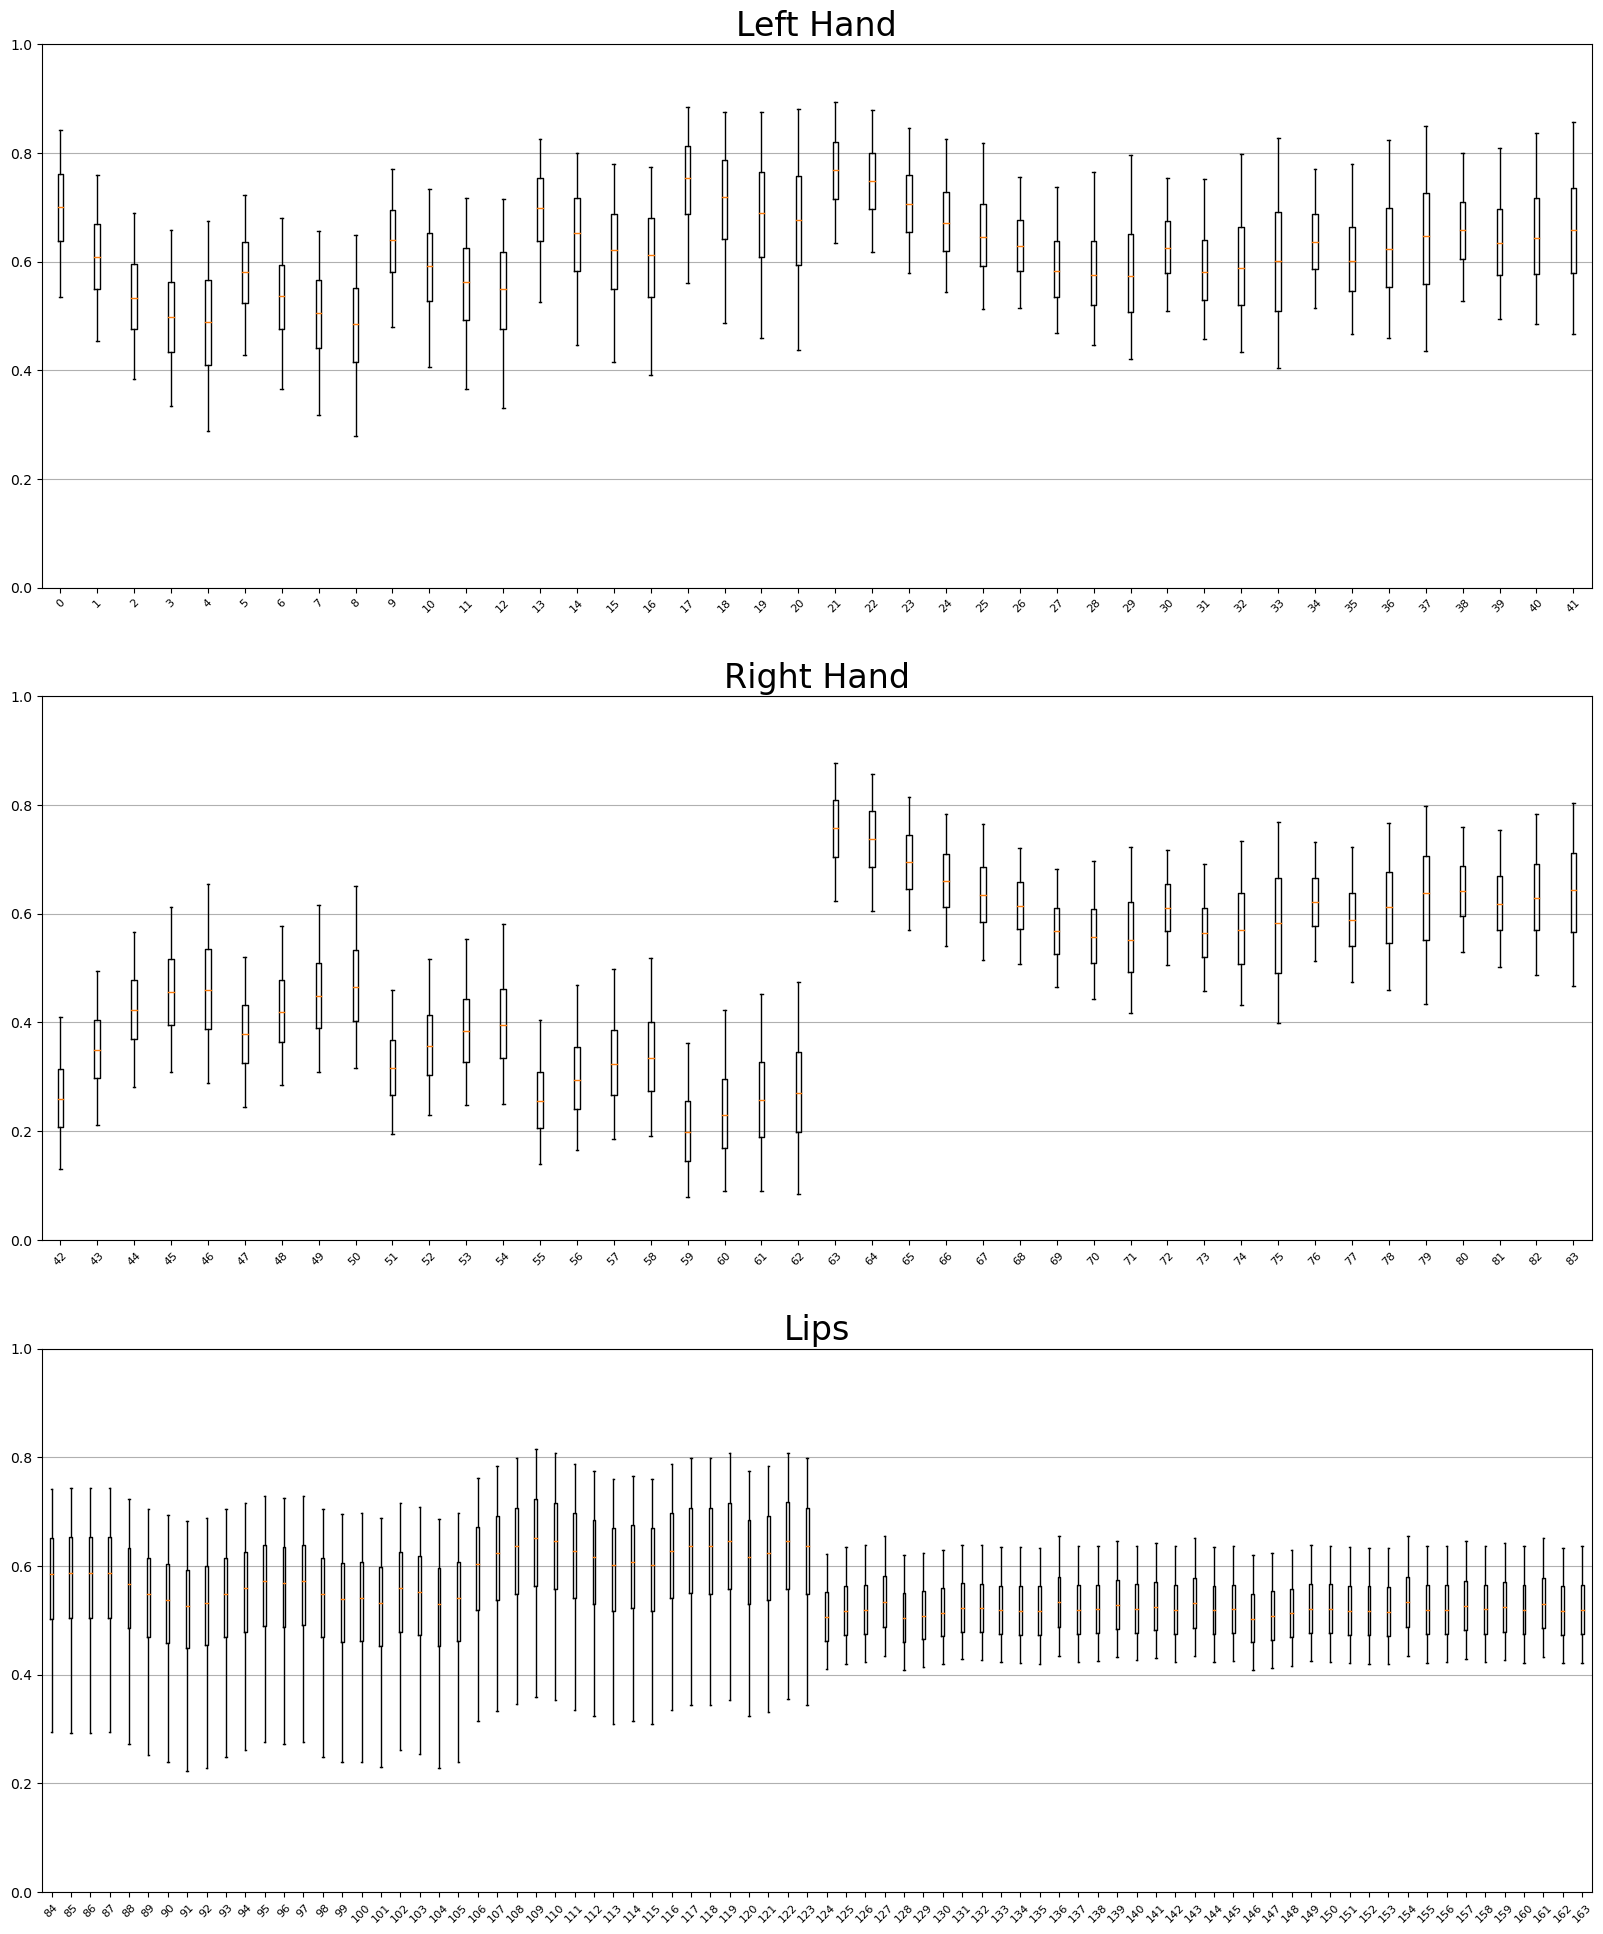

In [38]:
def get_left_right_hand_mean_std():
    # Dominant Hand Statistics
    MEANS = np.zeros([N_COLS], dtype=np.float32)
    STDS = np.zeros([N_COLS], dtype=np.float32)
    
    # Plot
    fig, axes = plt.subplots(3, figsize=(20, 3*8))
    
    # Iterate over all landmarks
    for col, v in enumerate(tqdm(X.reshape([-1, N_COLS]).T)):
        v = v[np.nonzero(v)]
        # Remove zero values as they are NaN values
        MEANS[col] = v.astype(np.float32).mean()
        STDS[col] = v.astype(np.float32).std()
        if col in LEFT_HAND_IDXS:
            axes[0].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        elif col in RIGHT_HAND_IDXS:
            axes[1].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        else:
            axes[2].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
    for ax, name in zip(axes, ['Left Hand', 'Right Hand', 'Lips']):
        ax.set_title(f'{name}', size=24)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
        ax.set_ylim(0.0, 1.0)
        ax.grid(axis='y')

    plt.show()
    
    return MEANS, STDS

# Get Dominant Hand Mean/Standard Deviation
MEANS, STDS = get_left_right_hand_mean_std()
# Save Mean/STD to normalize input in neural network model
np.save('MEANS.npy', MEANS)
np.save('STDS.npy', STDS)


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf



from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')


Tensorflow Version 2.12.0
Python Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [40]:
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding').T)

,,!,#,$,%,&,',(,),*,...,r,s,t,u,v,w,x,y,z,~
Ordinal Encoding,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58


In [41]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Verbose Setting during training
VERBOSE = 1 if IS_INTERACTIVE else 2
# Global Random Seed
SEED = 20 # Yay first change
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False

N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
print(f'Original number of unique characters {N_UNIQUE_CHARACTERS0}')
PAD_TOKEN = N_UNIQUE_CHARACTERS0 # This will be the position of Pad Token
SOS_TOKEN = N_UNIQUE_CHARACTERS0 + 1 # This will be the position of the SOS Token
EOS_TOKEN = N_UNIQUE_CHARACTERS0 + 2 # This will be the position of EOS Toekn
N_UNIQUE_CHARACTERS = N_UNIQUE_CHARACTERS0 + 3 # Total number of tokens
print(f'Total number of unique characters {N_UNIQUE_CHARACTERS}')
# Whether to use 30% of data for validation
USE_VAL = True
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 100
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05 # Regulaization to penalize large weights
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = True
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = False
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'


Original number of unique characters 59
Total number of unique characters 62


In [42]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

In [43]:
df = pd.read_parquet('/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet')
df.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,0,0.578892,0.578482,0.582906,0.572686,0.579030,0.582115,0.591430,0.498995,0.595773,...,-0.253687,-0.291687,-0.123892,-0.195255,-0.249135,-0.284375,-0.125050,-0.187797,-0.224827,-0.249662
1975433633,1,0.577563,0.578528,0.582916,0.572760,0.579090,0.582197,0.591687,0.497613,0.596104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975433633,2,0.576181,0.576949,0.581346,0.572293,0.577725,0.581191,0.591550,0.497113,0.596477,...,-0.233556,-0.267114,-0.116145,-0.179053,-0.223861,-0.253004,-0.122090,-0.173169,-0.200727,-0.219106
1975433633,3,0.575575,0.577569,0.581769,0.572443,0.578289,0.581652,0.591728,0.496759,0.596573,...,-0.190909,-0.218471,-0.093956,-0.149982,-0.188452,-0.211573,-0.102759,-0.147642,-0.168562,-0.180578
1975433633,4,0.577907,0.577628,0.582295,0.572930,0.578345,0.581873,0.592467,0.498170,0.597383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df.groupby(by=['sequence_id'])


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161461 entries, 1975433633 to 2008677531
Columns: 1630 entries, frame to z_right_hand_20
dtypes: float32(1629), int16(1)
memory usage: 1004.9 MB


In [46]:
df.shape

(161461, 1630)

In [47]:
MAX_FRAMES = df.loc[df.groupby(by ='sequence_id').size().idxmax()].shape[0]
print(f'Most frames for a single sequence we have in the parqet: {MAX_FRAMES}')

Most frames for a single sequence we have in the parqet: 751


In [48]:
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
    
# Set Train Indexed By sqeuence_id
train_sequence_id = train.set_index('sequence_id')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())


N_SAMPLES: 67208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


None

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [49]:
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

In [50]:
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/working/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')


Found 10 Inference Pickle Files


In [51]:
# TRAIN
X_train = np.load('/kaggle/working/X.npy')
y_train = np.load('/kaggle/working/y.npy')[:,:MAX_PHRASE_LENGTH]
N_TRAIN_SAMPLES = len(X_train)
print(f'X_train shape: {X_train.shape}')

X_train shape: (61955, 128, 164)


In [52]:
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

In [53]:
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1784552841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.474916,0.465197,0.464058,0.468163,0.463457,0.465313,0.464580,0.471774,0.459088,0.460689
1784552841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.476177,0.466883,0.465922,0.469732,0.465331,0.466998,0.466353,0.473127,0.460083,0.461722
1784552841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.478384,0.468958,0.467428,0.471166,0.466495,0.467893,0.468192,0.475056,0.460837,0.462567
1784552841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.477975,0.468895,0.467719,0.471272,0.466903,0.468244,0.468301,0.474836,0.461242,0.463176
1784552841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.477542,0.467444,0.466984,0.471405,0.466634,0.468635,0.467137,0.474729,0.462051,0.463873


In [54]:
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    """
    Returns column indices, or both column indices and names
    Input: dataframe, body_name, words/letters to exclude, get names or not, exact positions to get 
    """
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [55]:
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [56]:
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [57]:
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]
HAND_X_NAMES.shape, HAND_Y_NAMES.shape


((21,), (21,))

In [58]:
pd.Series(COLUMNS0).to_frame('columns').T

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
columns,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415


In [59]:
MEANS = np.load('/kaggle/working/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/working/STDS.npy').reshape(-1)

In [60]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

In [61]:
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[15]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)

    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')
    
    return data
    
if IS_INTERACTIVE:
    data = test_preprocess_layer()

In [62]:
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [63]:
train_dataset = get_train_dataset(X_train, y_train)

In [64]:
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 969


In [65]:
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [66]:
X_val = np.load('/kaggle/working/X_val.npy')
y_val = np.load('/kaggle/working/y_val.npy')[:,:MAX_PHRASE_LENGTH]
N_VAL_SAMPLES = len(X_val)

In [67]:
print(USE_VAL)
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)

True


In [68]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

N_VAL_STEPS_PER_EPOCH: 114


In [69]:
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 3
NUM_BLOCKS_DECODER = 2
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.20
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

# Learning Rate
LEARNING_RATE = 1e-4


In [70]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU), # Can change activation
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [71]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

In [72]:
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model, num_of_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads # Can change
        self.wq = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)] # depth//2 isn't common, we can try different numbers
        self.wk = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)]
        self.softmax = tf.keras.layers.Softmax()
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        
    def call(self, q, k, v, attention_mask=None, training=False):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](q)
            K = self.wk[i](k)
            V = self.wv[i](v)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn, axis=-1)
        multi_head_attention = self.wo(multi_head)
        multi_head_attention = self.do(multi_head_attention, training=training)
        
        return multi_head_attention

In [73]:
class EncoderTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, units, num_heads, mlp_ratio, mha_dropout_ratio, mlp_dropout_ratio, **kwargs):
        super(EncoderTransformerBlock, self).__init__(**kwargs)
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mha = MultiHeadAttention(units, num_heads, mha_dropout_ratio)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(units * mlp_ratio, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
            tf.keras.layers.Dropout(mlp_dropout_ratio),
            tf.keras.layers.Dense(units, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
        ])

    def call(self, inputs, attention_mask, training=False):
        x = self.layer_norm_1(inputs + self.mha(inputs, inputs, inputs, attention_mask=attention_mask))
        x = self.layer_norm_2(x + self.mlp(x))
        return x

In [74]:
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.support_masking = True
        self.blocks = [EncoderTransformerBlock(UNITS_ENCODER, NUM_HEADS, MLP_RATIO, MHA_DROPOUT_RATIO, MLP_DROPOUT_RATIO) for _ in range(num_blocks)]

        # Optional Projection to Decoder Dimension
        if UNITS_ENCODER != UNITS_DECODER:
            self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
            self.apply_dense_out = True
        else:
            self.apply_dense_out = False

    def call(self, x, x_inp, training=False):
        #Attention mask to ignore missing frames
        attention_mask = tf.where(tf.math.reduce_sum(x_inp, axis=[2]) == 0.0, 0.0, 1.0)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.repeat(attention_mask, repeats=N_TARGET_FRAMES, axis=1)
        
        # Iterate input over transformer blocks
        for block in self.blocks:
            x = block(x, attention_mask=attention_mask, training=training)
            
        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)
    
        return x


In [75]:
class DecoderTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, units, num_heads, mlp_ratio, mha_dropout_ratio, mlp_dropout_ratio, **kwargs):
        super(DecoderTransformerBlock, self).__init__(**kwargs)
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mha = MultiHeadAttention(units, num_heads, mha_dropout_ratio)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(units * mlp_ratio, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
            tf.keras.layers.Dropout(mlp_dropout_ratio),
            tf.keras.layers.Dense(units, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
        ])

    def call(self, inputs, encoder_outputs, attention_mask, training=False):
        x = self.layer_norm_1(inputs + self.mha(inputs, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
        x = self.layer_norm_2(x + self.mlp(x))
        return x

In [76]:
self_attention_mask =tf.ones((N_TARGET_FRAMES, N_TARGET_FRAMES))
self_attention_mask = tf.linalg.band_part(self_attention_mask, -1, 0)
tf.cast(self_attention_mask, tf.float32)

<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [77]:
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True

        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )

        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

        # Decoder Blocks
        self.blocks = [DecoderTransformerBlock(UNITS_DECODER, NUM_HEADS, MLP_RATIO, MHA_DROPOUT_RATIO,MLP_DROPOUT_RATIO) for _ in range(num_blocks)]

    def get_causal_attention_mask(self, B):
        # My version of the mask AM
        ones = tf.ones((N_TARGET_FRAMES, N_TARGET_FRAMES))
        mask = tf.linalg.band_part(ones, 0, -1)  
        mask = tf.transpose(mask)
        mask = tf.expand_dims(mask, axis=0)
        mask = tf.tile(mask, [B, 1, 1])
        mask = tf.cast(mask, tf.float32)
        return mask

    def call(self, encoder_outputs, phrase, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Causal Mask
        causal_mask = self.get_causal_attention_mask(B)
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=causal_mask))
        # Iterate input over causal_masktransformer blocks
        for block in self.blocks:
            x = block(x, encoder_outputs, causal_mask, training=training)
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
        return x

In [78]:
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

In [79]:
class CustomSCCEWithLS(tf.keras.losses.Loss):
    def __init__(self, loss_weights, pad_token=PAD_TOKEN, n_unique_characters=N_UNIQUE_CHARACTERS, label_smoothing=0.25, **kwargs):
        super().__init__(**kwargs)
        self.loss_weights = loss_weights
        self.pad_token = pad_token
        self.n_unique_characters = n_unique_characters
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # Filter Pad Tokens
        idxs = tf.where(y_true != self.pad_token)
        y_true = tf.gather_nd(y_true, idxs)
        y_pred = tf.gather_nd(y_pred, idxs)
        # One Hot Encode Sparsely Encoded Target Sign
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, self.n_unique_characters, axis=1)
        # Apply loss_weights
        y_true = y_true * self.loss_weights
        # Categorical Crossentropy with native label smoothing support
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=self.label_smoothing, from_logits=True)
        loss = tf.math.reduce_mean(loss)
        return loss

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "loss_weights": self.loss_weights.tolist(), "pad_token": self.pad_token, 
                "n_unique_characters": self.n_unique_characters, "label_smoothing": self.label_smoothing}

In [80]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp
    
    # Masking 
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)
    
    # Embedding
    x = Embedding()(x)
    
    # Encoder Transformer Blocks
    x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)
    
    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp)
    
    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False), # can changes initializer/activation
    ], name='classifier')(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)
    
    #optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # We should try different optimizers with learning rate scheduler
    
    # Create Initial Loss Weights All Set To 1
    loss_weights_tensor = tf.ones([N_UNIQUE_CHARACTERS], dtype=tf.float32)
    # Set Loss Weight Of Pad Token To 0
    loss_weights_tensor = tf.tensor_scatter_nd_update(loss_weights_tensor, [[PAD_TOKEN]], [0])

    # Convert the tensor to a numpy array
    loss_weights = loss_weights_tensor.numpy()

    # Categorical Crossentropy Loss With Label Smoothing
#     loss = scce_with_ls
    loss = CustomSCCEWithLS(loss_weights)

    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )
    
    return model

In [81]:
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 128, 164)
phrase: (1024, 32)


In [82]:
tf.keras.backend.clear_session()

model = get_model()

In [83]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
                                                                                                  
 encoder (Encoder)              (None, 128, 256)     2757120     ['embedding[0][0]',              
                                                                  'frames[0][0]']             

In [84]:
model.summary(expand_nested=True, show_trainable=True,)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 frames (InputLayer)            [(None, 128, 164)]   0           []                               Y          
                                                                                                             
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 Y          
                                                                                                             
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (Landm  multiple          210816      []                               Y       

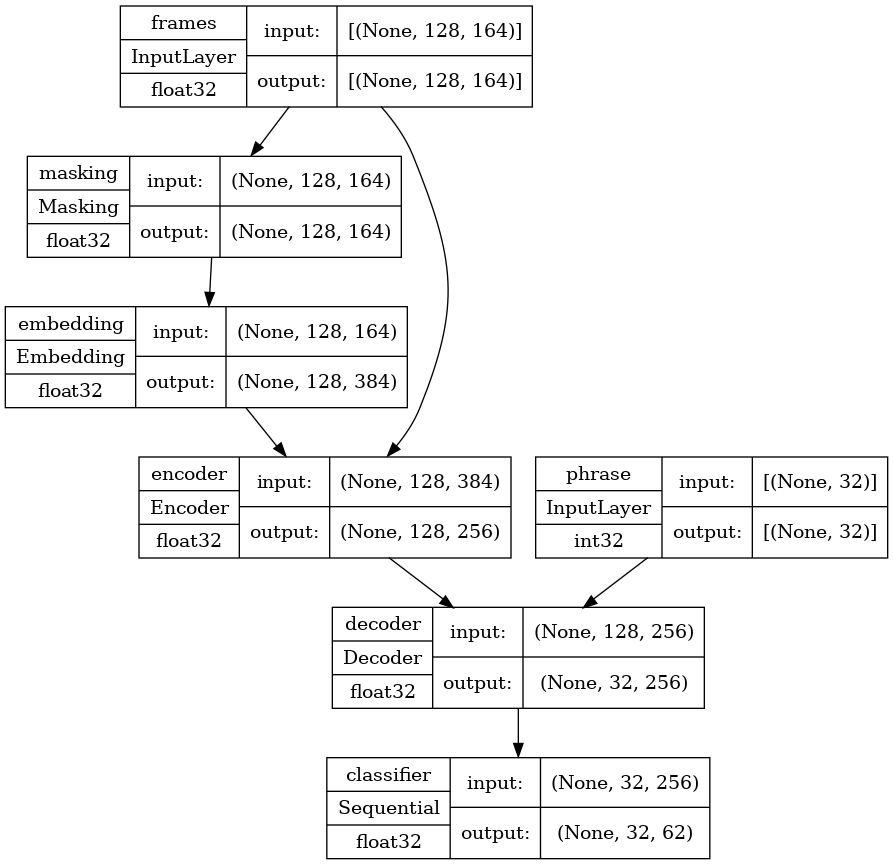

In [85]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)

In [86]:
history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=15,
            validation_data=val_dataset,
            validation_steps=N_VAL_STEPS_PER_EPOCH,
            verbose = VERBOSE,
        )


Epoch 1/15
969/969 - 2643s - loss: 3.3254 - top1acc: 0.2002 - top5acc: 0.5350 - val_loss: 3.1108 - val_top1acc: 0.2598 - val_top5acc: 0.6253 - 2643s/epoch - 3s/step
Epoch 2/15
969/969 - 2580s - loss: 3.1536 - top1acc: 0.2509 - top5acc: 0.6145 - val_loss: 3.0262 - val_top1acc: 0.3005 - val_top5acc: 0.6837 - 2580s/epoch - 3s/step
Epoch 3/15
969/969 - 2574s - loss: 3.0569 - top1acc: 0.2903 - top5acc: 0.6707 - val_loss: 2.9505 - val_top1acc: 0.3383 - val_top5acc: 0.7217 - 2574s/epoch - 3s/step
Epoch 4/15
969/969 - 2576s - loss: 2.9660 - top1acc: 0.3334 - top5acc: 0.7149 - val_loss: 2.8541 - val_top1acc: 0.3860 - val_top5acc: 0.7598 - 2576s/epoch - 3s/step
Epoch 5/15
969/969 - 2569s - loss: 2.8761 - top1acc: 0.3793 - top5acc: 0.7528 - val_loss: 2.7610 - val_top1acc: 0.4344 - val_top5acc: 0.7960 - 2569s/epoch - 3s/step
Epoch 6/15
969/969 - 2568s - loss: 2.8029 - top1acc: 0.4152 - top5acc: 0.7801 - val_loss: 2.6831 - val_top1acc: 0.4711 - val_top5acc: 0.8174 - 2568s/epoch - 3s/step
Epoch 7/15

In [87]:
model.save_weights('model.h5')

In [88]:
train_loss = history.history['loss']
train_top1acc = history.history['top1acc']
train_top5acc = history.history['top5acc']

val_loss = history.history['val_loss']
val_top1acc = history.history['val_top1acc']
val_top5acc = history.history['val_top5acc']

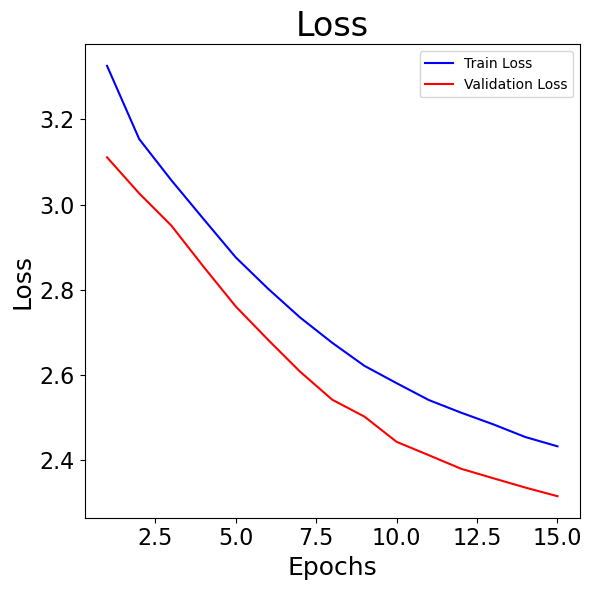

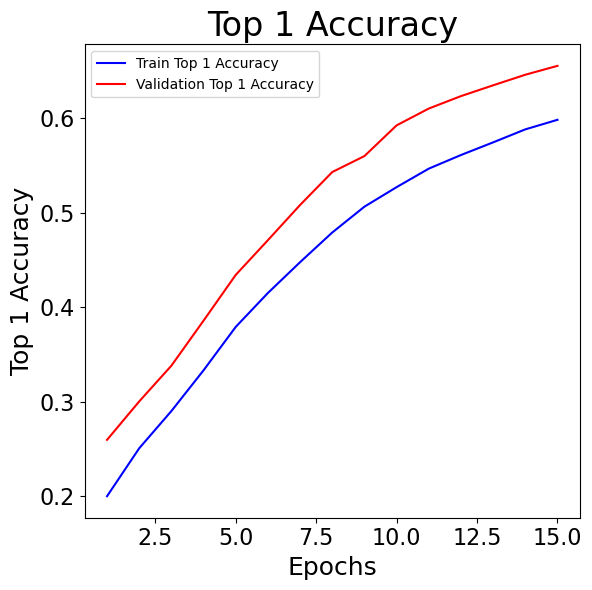

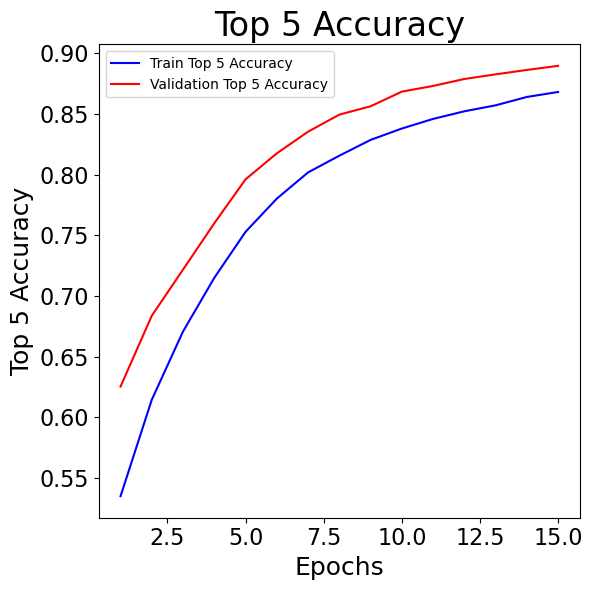

In [89]:
epochs = range(1, len(val_loss) + 1)

# Plotting Loss
plt.figure(figsize=(6,6))
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show();

# Plotting Accuracy
plt.figure(figsize=(6,6))
plt.plot(epochs, train_top1acc, 'b', label='Train Top 1 Accuracy')
plt.plot(epochs, val_top1acc, 'r', label='Validation Top 1 Accuracy')
plt.title('Top 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 1 Accuracy')
plt.legend()
plt.tight_layout()

plt.show();

plt.figure(figsize=(6,6))
plt.plot(epochs, train_top5acc, 'b', label='Train Top 5 Accuracy')
plt.plot(epochs, val_top5acc, 'r', label='Validation Top 5 Accuracy')
plt.title('Top 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 5 Accuracy')
plt.legend()
plt.tight_layout()

plt.show();

In [90]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [91]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [92]:
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([ORD2CHAR.get(s, '') for s in outputs])


In [93]:
@tf.function()
def predict_phrase(batch_frames):
    batch_frames = tf.convert_to_tensor(batch_frames)
    phrase = tf.fill([batch_frames.shape[0], MAX_PHRASE_LENGTH], PAD_TOKEN)
    phrase = tf.cast(phrase, tf.int32) # Cast phrase to int32 initially
    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Predict Next Token
        outputs = model({
            'frames': batch_frames,
            'phrase': phrase,
        })
        
        phrase = tf.where(
            tf.range(MAX_PHRASE_LENGTH)[None, :] < idx + 1,
            tf.argmax(outputs, axis=-1, output_type=tf.int32),
            phrase,
        )
    # one-hot encode the outputs
    outputs_one_hot = tf.one_hot(phrase, depth=N_UNIQUE_CHARACTERS)
    return outputs_one_hot

In [94]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)
        
        return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        # Predict One Token At A Time
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == EOS_TOKEN
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
demo_sequence_id = example_parquet_df.index.unique()[0]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')


demo_raw_data shape: (294, 164), dtype: float32
demo_output shape: (32, 62), dtype: float32
demo_outputs phrase decoded: https://www.nzperaperol.waog
phrase true: https://www.xn--pearol-xwa.org


In [95]:
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)

In [96]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [97]:
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json

  adding: kaggle/working/model.tflite (deflated 9%)
  adding: kaggle/working/inference_args.json (deflated 83%)
